# Deriving the LF parameter prior

TL;DR

All LF model parameters can be derived from statistics in [@Holmberg1988, Tables A1-A2] for an American population. See `holmberg.ipynb`. See [@Holmberg1989] for a good explanation of these statistics (that's where the abbreviations like ACFL come from). The statistics are:

1. $T_0$, the pitch period
2. $T_d = U_0/E_e$, the declination time. $U_0$ = **ac flow** (ACFL) and $E_e$ = **maximum airflow declination rate** (MFDR).
3. $E_e$: the vertical amplitude.
4. $O_q$: the open quotient,
5. $\alpha_m$, via the **speed quotient** (SPQU) $S_q$ and thus $\alpha_m$ by $\alpha_m = 3_q/(1+S_q)$ (Doval 2006).
6. $Q_a$, via the **closing quotient** (CLQU): $Q_a \simeq t_2/t_3 = CLQU/(1-O_q)$

However, these are _marginal_ statistics and don't capture correlations. The correlations can be supplied using Fant (1994)'s "transformed LF" model. The three **'driving variables'** from which all other are regressed are:

1. $T_0$, the pitch period (we derive a prior for this)
2. $T_d$, the declination time (we derive a prior for this)
3. $E_e$: the vertical amplitude (always one because we work modulo scaling)

Thus, the secondary variables which are calculated from the three previous ones are:

1. $O_q$,
2. $\alpha_m$
3. $Q_a$

Bounds for all these variables can be deduced from Holmberg (1988, 1989a). But we use the theoretical bounds as this is easier and won't influence the results downstream for $\theta$ anyway.

The regression happens through Fant (1994). There are three equivalent sets of parameters, which can be converted to one another with `lfmodel.convert_lf_params()`:

1. The `T` set: original LF parameters (Fant 1985) which are used in `lfmodel.dgf()`.
2. The `R` set: rescaled ("ratios") LF parameters which can be regressed from $(T_0, T_d, E_e)$ per Fant (1994)
3. The `generic` set per Doval (2006). This is a set of variables which is well-behaved and properly bounded and 'universal'; therefore it is the set we actually model with our prior `lf.generic_params_prior()`.

## Nice quotes about LF

Note: LF does not allow **negative flow**, like ours. The only GF model that does that is the Fujisaki model:

> Note that contrarily to all other models, this [Fujisaki]
> one does not exclude a negative flow due for instance to a lowering of the vocal folds following the
> glottal closure. [@Degottex2010, p. 35]

LF model is the most used:

> Besides being the most used model, this one is also the
> most studied in terms of spectral properties [van03, Hen01, DdH06, FL88] [@Degottex2010, p. 35]

Use the LF model to control phonation mode with the `Re` parameter: (called `Rd` here)

> This allows one to easily control the voice source with
> a single parameter, which runs from Rd = 0.3 for a very adducted phonationtense, to Rd = 2.7 for a very abducted phonation
> (see [@Fant1995]). From the Rd range [0.3, 2.7] two extreme values
> plus a middle one were chosen. We used Rd = 0.3 to generate a **tense** phonation, Rd = 2.7 for a **lax** production, and
> Rd = 1 for a **normal (modal)** voice quality [@Freixes2018]


In [8]:
from surrogate import period
from surrogate import lf
from utils import constants
from utils import lfmodel
from utils import klatt
from utils.jax import vk
import corner

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Sampling Fant's `R` parameters

Note that `Rg` can be larger than 1, unlike `Ra `and `Rg` (Fant 1994, Fig. 3), because it is actually an inverse ratio: $R_g = T_0/2T_p$.


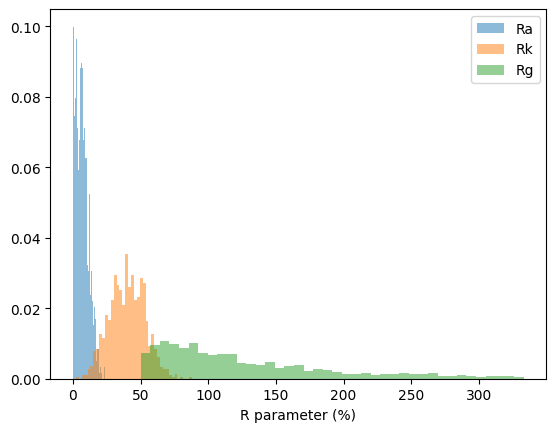

In [2]:
rng = np.random.default_rng()

samples = np.vstack(
    [lf.sample_R_triple(Re, rng) for Re in rng.uniform(0.3, 2.7, size=1000)]
)
R = dict(Ra=samples[:, 0], Rk=samples[:, 1], Rg=samples[:, 2])

for k, v in R.items():
    plt.hist(v * 100, density=True, bins=40, alpha=0.5, label=k)

plt.legend()
plt.xlabel("R parameter (%)")
plt.show()

## Sampling the LF parameters and fitting a prior

`p` contains all three parametrizations: `R`, `T`, and `generic`.


In [3]:
%%time
p = lf.sample_lf_params()

[Memory]0.7s, 0.0min    : Loading sample_lf_params...
CPU times: user 102 ms, sys: 205 ms, total: 307 ms
Wall time: 302 ms


In [4]:
samples = np.vstack([p[v] for v in constants.LF_GENERIC_PARAMS]).T
samples.shape

(63502, 4)

One interesting extra correlation not shown here is that of `p['power']` with the generic LF parameters. It has the clearest, most Gaussian-like correlations (in the z domain) but is strictly not an LF generic parameter, so not shown here.


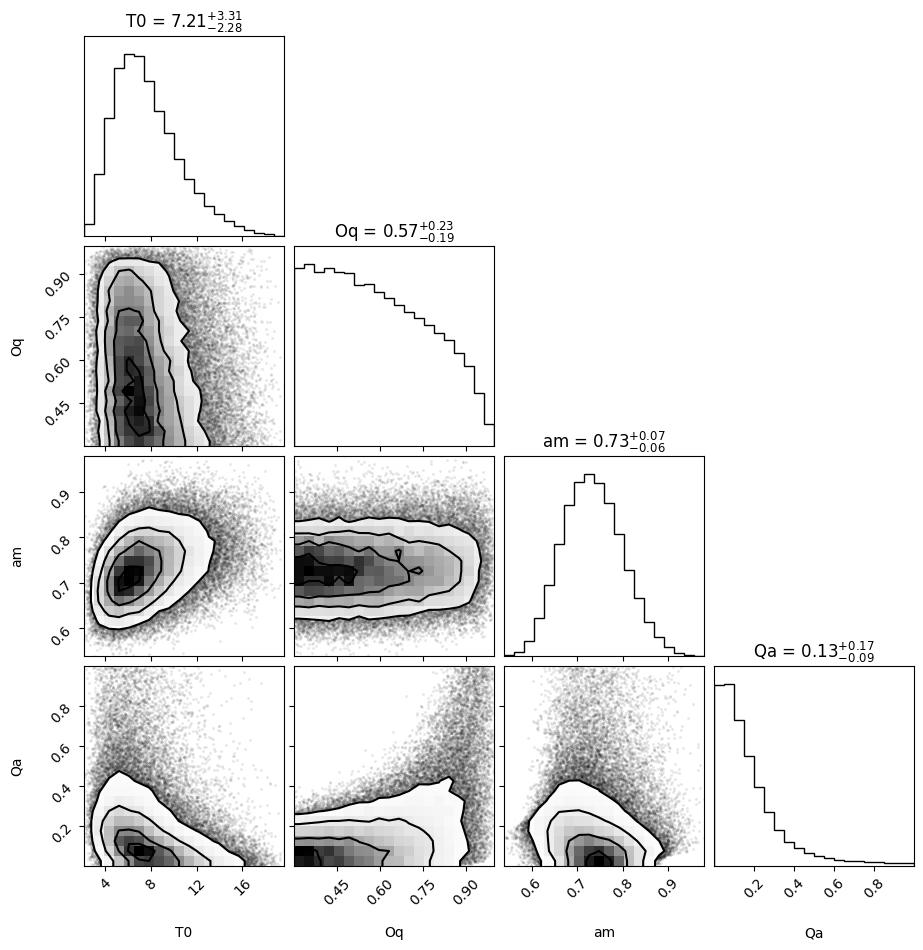

In [5]:
# Cornerplot of regressed (simulated) samples
fig = corner.corner(
    samples, labels=constants.LF_GENERIC_PARAMS, show_titles=True, smooth=0.2
)

In [6]:
prior = lf.generic_params_prior()

[Memory]2.1s, 0.0min    : Loading sample_lf_params...


[Memory]2.5s, 0.0min    : Loading run_nested...


The samples and their probability are well behaved, unlike with our previous version where there would be ginormous outliers of the log prob.


In [9]:
theta, theta_lp = prior.experimental_sample_and_log_prob(
    samples.shape[0], seed=vk(10)
)

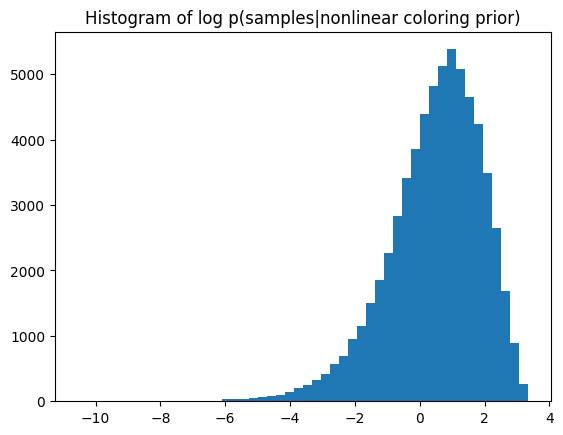

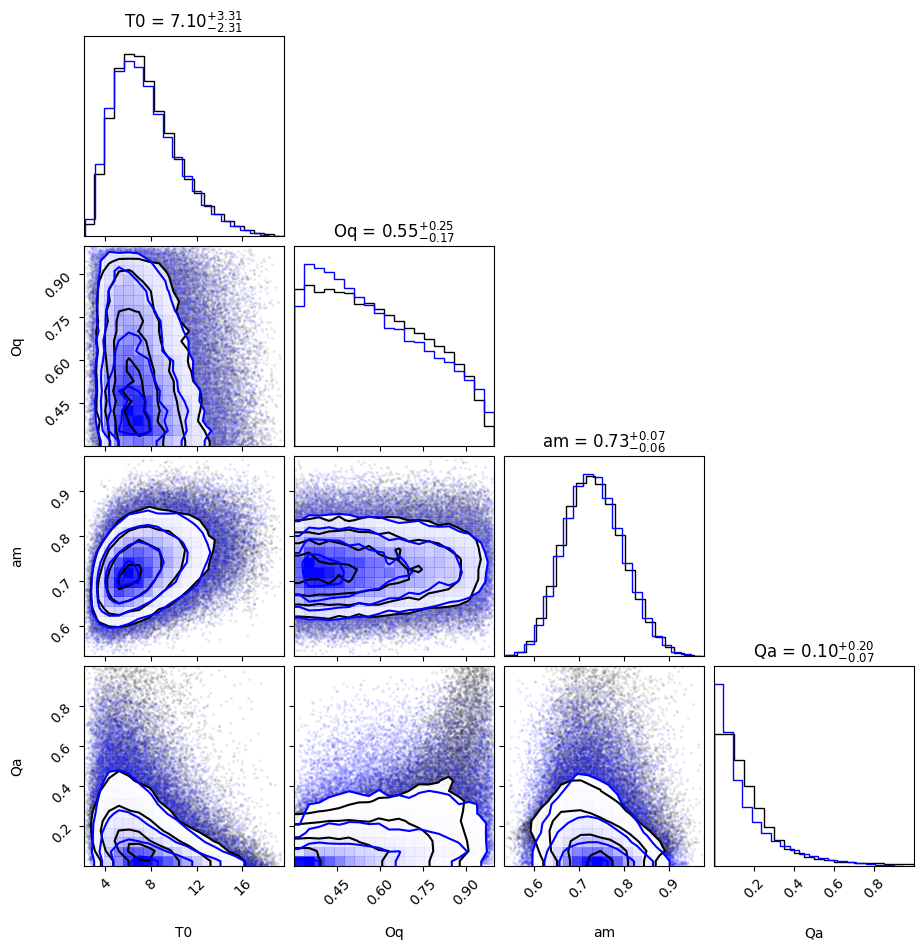

In [10]:
plt.hist(np.array(theta_lp), bins=50)
plt.title("Histogram of log p(samples|nonlinear coloring prior)")
plt.show()
# Overlaying with an alpha is not possible, see https://github.com/dfm/corner.py/issues/112
corner.corner(
    np.array(theta),
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=0.2,
    fig=fig,
    color="blue",
)

## Simulate trajectories of the generic LF parameters

The envelope function is the one of the period learned from APLAWD.


[Memory]77.4s, 1.3min   : Loading sample_lf_params...
[Memory]77.4s, 1.3min   : Loading run_nested...
[Memory]77.5s, 1.3min   : Loading get_aplawd_training_pairs_subset...
[Memory]122.2s, 2.0min  : Loading run_nested...
[Memory]140.0s, 2.3min  : Loading run_nested...
[Memory]157.4s, 2.6min  : Loading run_nested...
[Memory]175.7s, 2.9min  : Loading run_nested...
log p(x) = 405.2439670037309


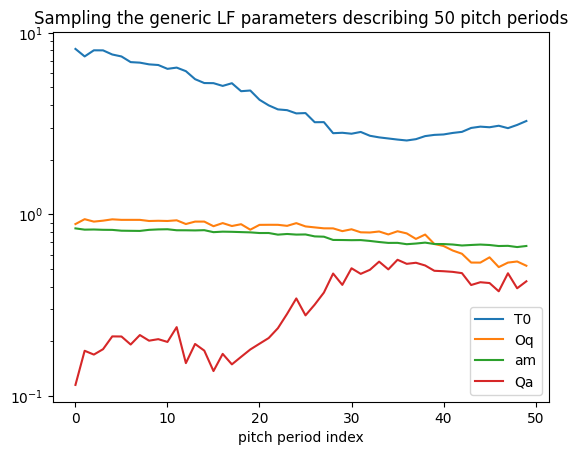

In [11]:
num_pitch_periods = 50

prior = lf.generic_params_trajectory_prior(num_pitch_periods)

x = prior.sample(seed=vk(5))

plt.title(
    f"Sampling the generic LF parameters describing {num_pitch_periods} pitch periods"
)
plt.plot(x, label=constants.LF_GENERIC_PARAMS)
plt.yscale("log")
plt.legend()
plt.xlabel("pitch period index")

print("log p(x) =", prior.log_prob(x))

## Convert the trajectories into DGF waveforms

The inferred lengthscale sounds rushed, but this is normal and due to the data: we learned the lengthscale from generally short fragments of voiced speech, with 75% of data points having a length of less than 53 consecutive pitch periods.


#### Failure modes: `fs` too small

The _log likelihood calculation_ can fail when the DGF waveform features become extremely sharp: i.e., when there is a _very_ short or nonexistent return phase that is unresolved by the sampling rate (i.e. the gap between the samples near the end of the DGF is too large because there are not enough samples interpolating the sharp return). **But this problem can be solved simply by we increasing the sampling rate `fs` to resolve the sharp return phase.**

- For our sampling rate `fs = 10 kHz`, these failures start to become likely at O(500) number of pitch periods, meaning that the underlyign latent GP controlling the LF parameters starts generating unlikely LF parameters that cause the failure only at O(500) "tries".

The _DGF waveform calculation_ itself also fails at the same problem (return phase too fast), but is more robust to lower `fs`'s. The underlying GP now needs O(1000) "tries", and the same fix (increasing `fs` applies).


[Memory]240.8s, 4.0min  : Loading sample_lf_params...
[Memory]240.9s, 4.0min  : Loading run_nested...
CPU times: user 6.7 s, sys: 284 ms, total: 6.98 s
Wall time: 8.86 s


Array(253.63249381, dtype=float64)

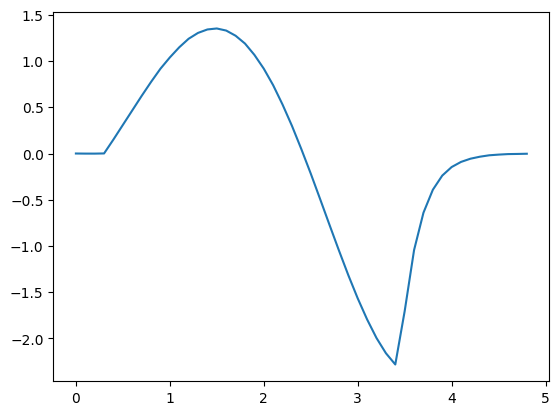

In [17]:
%%time


def scope():
    prior = lf.generic_params_prior()
    t, u, lp = lf.sample_and_log_prob_dgf(prior, vk(13))
    plt.plot(t, u)
    return lp


scope()

[Memory]325.2s, 5.4min  : Loading sample_lf_params...
[Memory]325.3s, 5.4min  : Loading run_nested...


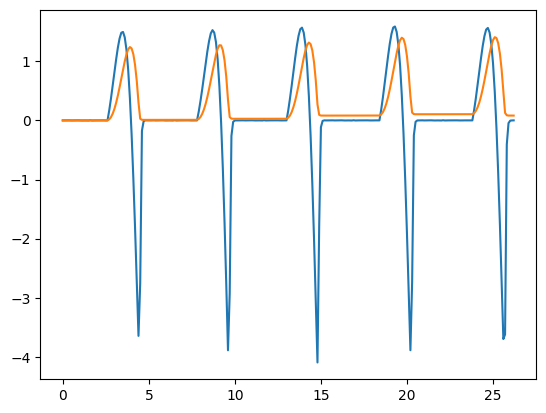

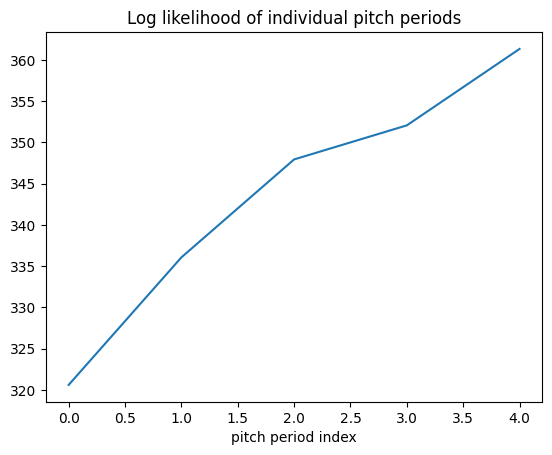

CPU times: user 9.08 s, sys: 248 ms, total: 9.33 s
Wall time: 12.2 s


Array(1747.83869259, dtype=float64)

In [20]:
%%time


def scope(num_pitch_periods, seed):
    prior = lf.generic_params_trajectory_prior(num_pitch_periods)
    t, u, lp, context = lf.sample_and_log_prob_dgf(
        prior, seed, num_pitch_periods, return_full=True
    )
    plt.plot(t, u)
    plt.plot(t, np.cumsum(u) * (t[1] - t[0]))
    plt.show()
    plt.plot(context["logls"])
    plt.title("Log likelihood of individual pitch periods")
    plt.xlabel("pitch period index")
    plt.show()
    return lp


scope(5, vk())

## Convolve with a vowel

- It is possible to set `noise_floor_power=0.` in the call to `sample_and_log_prob_dgf()`: this does not affect the sound.
- The probability of the resulting vowel can be calculated with a similar Laplace approximation for which the convolution needs to be differentiated, but we don't do that here
- Better poles for a vowel can be extracted from the steady state vowel work.


[Memory]360.9s, 6.0min  : Loading sample_lf_params...
[Memory]360.9s, 6.0min  : Loading run_nested...
Log prob of underlying DGF waveform: 362419.82004410034


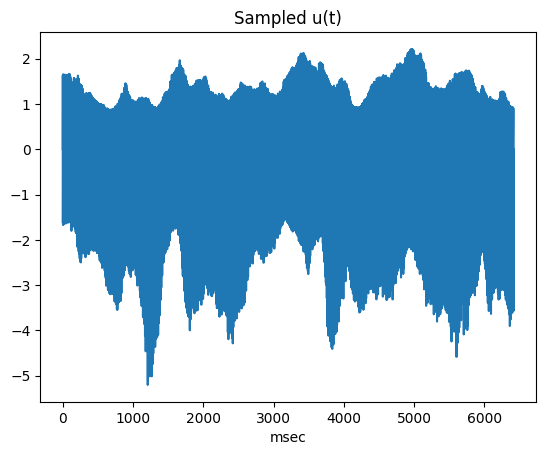

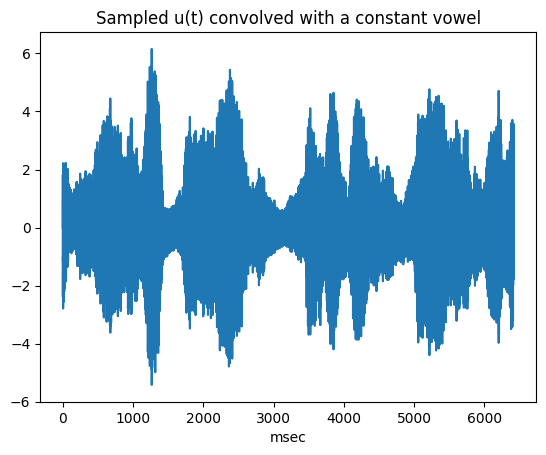

In [ ]:
num_pitch_periods = 1000
vowel = 10

# A None value uses the fitted value for the period GP
envelope_kernel_name = None
envelope_lengthscale = None
envelope_noise_sigma = None

prior = lf.generic_params_trajectory_prior(num_pitch_periods)

t, u, log_prob_u = lf.sample_and_log_prob_dgf(prior, vk(), num_pitch_periods)

print("Log prob of underlying DGF waveform:", log_prob_u)

plt.title(f"Sampled u(t)")
plt.plot(t, u)
plt.xlabel("msec")
plt.show()

t, d = klatt.gen_vowel(vowel, u, t)
plt.title(f"Sampled u(t) convolved with a constant vowel")
plt.plot(t, d)
plt.xlabel("msec")
plt.show()
klatt.play(t, d)